# Using Redrock for specz

Using `Redrock v. 0.4.1`

In [1]:
# Tell my code where to find the modules used which aren't in anaconda
import sys
sys.path.append('/Users/greg/redrock-0.4.1/py/redrock/') # redrock
sys.path.append('/Users/greg/elg_cgm/elg_cgm/') # elg_cgm template stuff
sys.path.append('/Users/greg/desisim/py/') # DESI tools

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import redrock.dataobj as obj
import astropy.units as u
import redrock.io as rrio
from linetools.spectra.xspectrum1d import XSpectrum1D
from elg_cgm import elgUtils as elg
from linetools.spectra.utils import rebin
from astropy.io import fits
from astropy.table import Table
from desisim.pixelsplines import gauss_blur_matrix as gbm
from pkg_resources import resource_filename
import h5py
import scipy

In [3]:
#Song's function for importing hdf5 data
def load_spec_kast_hdf5(hdf5_file):
    hdf5_data = h5py.File(hdf5_file, 'r')
    hdf5_key = hdf5_data.keys()[0]
    hdf5_spec = hdf5_data[hdf5_key][0]
    
    return hdf5_spec[0], hdf5_spec[1], hdf5_spec[2]

In [4]:
data_pth = '/Users/greg/Desktop/redwoodforest/kast_7-14-17/new_sig_redux/kast_red_setup_A/science/'

## 1) J1617+4232

In [5]:
#spec1_file = '/Users/gsallabe/Desktop/new_sig_redux/kast_red_setup_A/science/J1617+4232_coadd_new.hdf5'
#spec1_wav, spec1_flux, spec1_err = load_spec_hdf5(spec1_file)

To simplify and keep the reductions to the template format, I will do this galaxy using .fits file data

In [6]:
spec1_file = data_pth + 'J1617+4232_coadd_new.fits'

hdulist = fits.open(spec1_file)
#since the data is already a coadded 1dspec, extract data via the following method
flux1 = hdulist['FLUX'].data/u.AA
wav1 = hdulist['WAVELENGTH'].data*u.AA
err1 = hdulist['ERROR'].data
sig1 = np.sqrt(err1)

#Create Xspectrum1D object
spec = XSpectrum1D.from_tuple((wav1,flux1,sig1),verbose = True)



We have 1 spectra with 2725 pixels each.


#Rebin to constant velocity bins
newSpec = elg.rebin2ConstVel(spec, do_sig = True)

Since the rejected pixels are causing an issue, will need to use `elg.rebin2ConstVel(grow_bad_sig = True)`

In [7]:
newSpec = elg.rebin2ConstVel(spec, do_sig = True, grow_bad_sig = True)

Since it's not screaming errors at me, I will assume that worked. Now, continuing with the code from the elg_cgm template...

In [8]:
#Create resolution matrix
pixbound = np.append(newSpec.wavelength.value, spec.wvmax.value)
sig_conv = newSpec.sig.value

In [9]:
# This cell is essentially just to check on the resolution matrix.
# The reduction requires that all values of the matrix are <0,
# so this spits out the minimum value and any elements that are 
# zero along with their associated index and wavelength value.
# The strategy (for now) is to just cut the wavelength range to eliminate the bad values.
# Just minimize the output window

print 'minimum value is',np.min(sig_conv)
for i in range(len(sig_conv)):    
    if sig_conv[i] <= 0.:
        print i,sig_conv[i],wav1[i]
        #sig_conv[i] = .1
print np.max(sig_conv)

minimum value is 0.0
26 0.0 4540.89081212 Angstrom
27 0.0 4542.07670647 Angstrom
28 0.0 4543.26275604 Angstrom
29 0.0 4544.44896066 Angstrom
30 0.0 4545.63532025 Angstrom
31 0.0 4546.82183471 Angstrom
32 0.0 4548.00850392 Angstrom
33 0.0 4549.19532778 Angstrom
34 0.0 4550.38230617 Angstrom
35 0.0 4551.56943898 Angstrom
36 0.0 4552.75672609 Angstrom
37 0.0 4553.9441674 Angstrom
38 0.0 4555.13176277 Angstrom
39 0.0 4556.31951211 Angstrom
40 0.0 4557.5074153 Angstrom
41 0.0 4558.69547222 Angstrom
42 0.0 4559.88368277 Angstrom
55 0.0 4575.3443477 Angstrom
56 0.0 4576.53469702 Angstrom
57 0.0 4577.72519826 Angstrom
58 0.0 4578.91585129 Angstrom
59 0.0 4580.10665603 Angstrom
1238 0.0 6059.49938343 Angstrom
1239 0.0 6060.79349465 Angstrom
1240 0.0 6062.08763224 Angstrom
1851 0.0 6854.05505146 Angstrom
1852 0.0 6855.34738941 Angstrom
1853 0.0 6856.63969599 Angstrom
2235 0.0 7347.17772956 Angstrom
2236 0.0 7348.4515505 Angstrom
2237 0.0 7349.72530663 Angstrom
2238 0.0 7350.99899788 Angstrom
223

Not all of the sigma values are >0. I will assume that these are bad pixels. Cutting these out (aggressively) will leave me with a range of $\lambda \sim 4600-6000 \AA $.

In [44]:
# Now I am going to re-do the above, but with a significantly smaller array based on the above.

flux1_cut = flux1[60:1019]
wav1_cut = wav1[60:1019]
err1_cut = err1[60:1019]
sig1_cut = sig1[60:1019]

#Create Xspectrum1D object
spec_cut = XSpectrum1D.from_tuple((wav1_cut,flux1_cut,sig1_cut),verbose = True)
newSpec_cut = elg.rebin2ConstVel(spec_cut, do_sig = True, grow_bad_sig = True)

#Create resolution matrix
pixbound = np.append(newSpec_cut.wavelength.value, spec_cut.wvmax.value)
sig_conv = newSpec_cut.sig.value

# check sig_conv again
print 'Minimum sigma value is',np.min(sig_conv)
for i in range(len(sig_conv)):    
    if sig_conv[i] <= 0.:
        print i,sig_conv[i],wav1[i]
        sig_conv[i] = np.median(sig_conv)
print "Wavelength coverage is", wav1_cut[0], "-", wav1_cut[-1]
print np.shape(sig_conv), np.shape(pixbound) # check for 1-element difference

We have 1 spectra with 959 pixels each.
Minimum sigma value is 0.546013
Wavelength coverage is 4581.29761233 Angstrom - 5775.61425191 Angstrom
(954,) (955,)


In [11]:
r = gbm(pixbound,sig_conv)

# Create redrock spectrum object and target object
rrSpecObj = obj.Spectrum(flux = newSpec_cut.flux.value,
                         ivar = 1/newSpec_cut.sig.value**2,
                         wave = newSpec_cut.wavelength.value,
                         R = r)
rrTargObj = obj.Target('J1617+4232', [rrSpecObj])


# get the galaxy template
rrio.find_templates(template_dir='/Users/greg/redrock-templates/')
galTemp = rrio.read_template(rrio.find_templates(template_dir='/Users/greg/redrock-templates/')[0])

# Note:

`rrio.find_templates()` takes an argument `template_dir` which defaults to `template_dir=None`. This is where we want to put the path to `/redrock-templates/`

In [12]:
galTemp.redshifts = np.linspace(start = 0.3, stop = 0.5, num = 1000)

In [13]:
from redrock.zfind import zfind
zscan, zfit = zfind([rrTargObj], [galTemp])

INFO: using multiprocessing with 2 cores
DEBUG: PID 3991 starting zchi2 scan for GALAXY


<IPython.core.display.Javascript object>


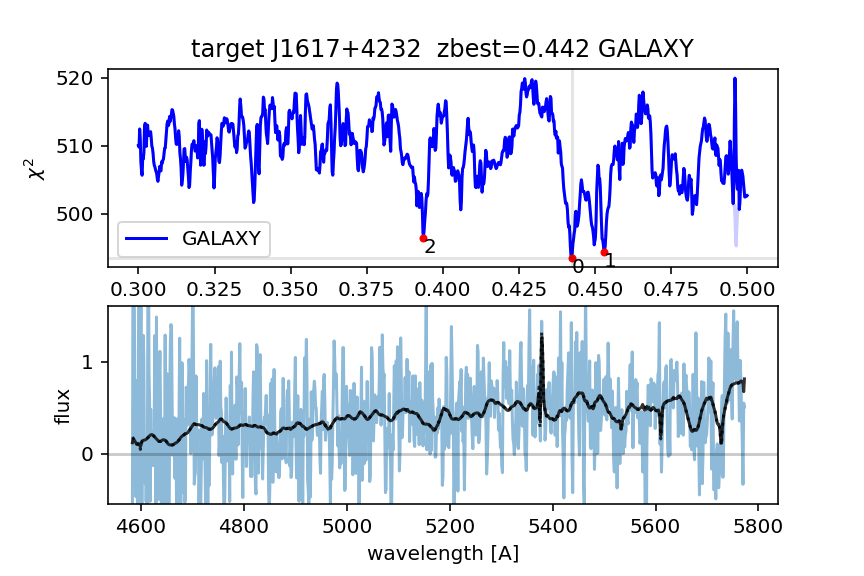

-------------------------------------------------------------------------
Select window then use keyboard shortcuts to navigate:
    up/down arrow: previous/next target
    left/right arrow: previous/next redshift fit for this target
    (d)etails
-------------------------------------------------------------------------
target 0 id J1617+4232 znum 0 GALAXY z=0.442


In [20]:
%matplotlib notebook
from redrock.plotspec import PlotSpec as ps
intPlots = ps([rrTargObj],[galTemp],zscan,zfit)
intPlots

In [15]:
zfit

chi2,coeff [10],z,zerr,zwarn,zz [15],zzchi2 [15],spectype,subtype,targetid,znum,deltachi2
float64,float64,float64,float64,int64,float64,float64,str6,str1,str10,int64,float64
493.526793273,-129.62954553 .. -72.0734154296,0.442312903238,0.000210374509927,4,0.442142142142 .. 0.442542542543,493.73577837 .. 494.307994633,GALAXY,,J1617+4232,0,0.812861200422
494.339654474,260.132001027 .. 109.876675225,0.453038749932,0.000217421620215,4,0.452752752753 .. 0.453153153153,495.426460395 .. 494.608921041,GALAXY,,J1617+4232,1,2.07302178815
496.412676262,-310.794476349 .. -15.5237371875,0.393585675192,0.000116190529414,4,0.393493493493 .. 0.393893893894,497.101024029 .. 497.798404364,GALAXY,,J1617+4232,2,0.0


# 2) J1620+4227

In [52]:
data_pth2 = '/Users/greg/Desktop/redwoodforest/kast_7-14-17/redux/kast_red_setup_A/science/'
spec2_file = data_pth2 + "J1620+4227_coadd.fits"

hdulist2 = fits.open(spec2_file)
flux2 = hdulist2['FLUX'].data/u.AA
wav2 = hdulist2['WAVELENGTH'].data*u.AA
err2 = hdulist2['ERROR'].data
sig2 = np.sqrt(err2)

flux2_cut = flux2[60:1019] #using the same range as the above galaxy
wav2_cut = wav2[60:1019]
err2_cut = err2[60:1019]
sig2_cut = sig2[60:1019]

In [53]:
# Now I'm going to try a more proactive and efficient way of dealing with the sigma array
print "Minimum sigma value is" , np.min(sig2_cut)
for i in range(len(sig2_cut)):
    if sig2_cut[i] <=0.:
        print i , sig2_cut[i] , wav2_cut[i] , "... Fixing zero values with median value"
        sig2_cut[i] = np.median(sig2_cut)
print "New minimum is" , np.min(sig2_cut)

Minimum sigma value is 0.0
0 0.0 4580.16036346 Angstrom ... Fixing zero values with median value
1 0.0 4581.35135174 Angstrom ... Fixing zero values with median value
2 0.0 4582.54249151 Angstrom ... Fixing zero values with median value
3 0.0 4583.73378266 Angstrom ... Fixing zero values with median value
4 0.0 4584.92522506 Angstrom ... Fixing zero values with median value
5 0.0 4586.11681861 Angstrom ... Fixing zero values with median value
6 0.0 4587.3085632 Angstrom ... Fixing zero values with median value
7 0.0 4588.5004587 Angstrom ... Fixing zero values with median value
8 0.0 4589.69250501 Angstrom ... Fixing zero values with median value
9 0.0 4590.88470202 Angstrom ... Fixing zero values with median value
10 0.0 4592.07704961 Angstrom ... Fixing zero values with median value
11 0.0 4593.26954766 Angstrom ... Fixing zero values with median value
12 0.0 4594.46219607 Angstrom ... Fixing zero values with median value
13 0.0 4595.65499472 Angstrom ... Fixing zero values with medi

In [54]:
#Create Xspectrum1D object
spec_cut2 = XSpectrum1D.from_tuple((wav2_cut,flux2_cut,sig2_cut),verbose = True)
newSpec_cut2 = elg.rebin2ConstVel(spec_cut2, do_sig = True, grow_bad_sig = True)

pixbound2 = np.append(newSpec_cut2.wavelength.value, spec_cut2.wvmax.value)
sig_conv2 = newSpec_cut2.sig.value

We have 1 spectra with 959 pixels each.


In [55]:
r2 = gbm(pixbound2,sig_conv2)

# Create redrock spectrum object and target object
rrSpecObj2 = obj.Spectrum(flux = newSpec_cut2.flux.value,
                         ivar = 1/newSpec_cut2.sig.value**2,
                         wave = newSpec_cut2.wavelength.value,
                         R = r2)
rrTargObj2 = obj.Target('J1620+4227', [rrSpecObj2])

INFO: using multiprocessing with 2 cores
DEBUG: PID 3991 starting zchi2 scan for GALAXY


<IPython.core.display.Javascript object>


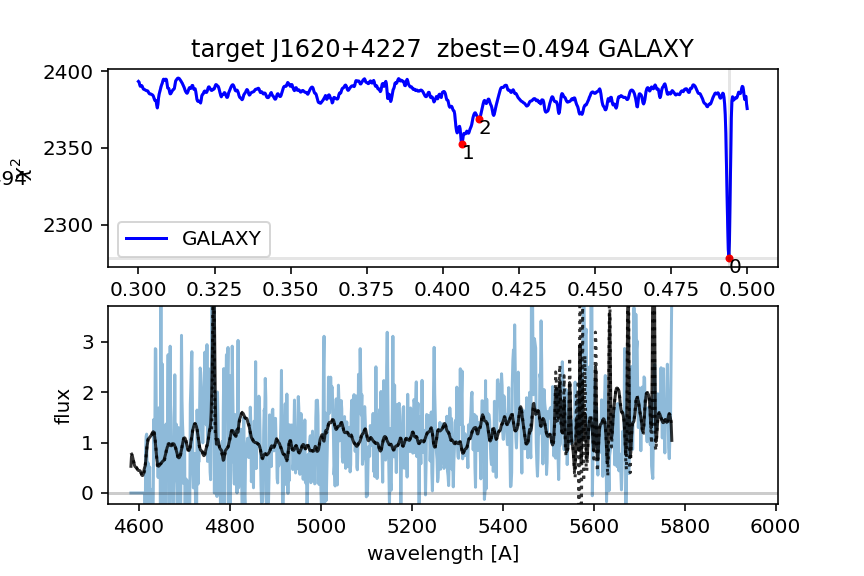

-------------------------------------------------------------------------
Select window then use keyboard shortcuts to navigate:
    up/down arrow: previous/next target
    left/right arrow: previous/next redshift fit for this target
    (d)etails
-------------------------------------------------------------------------
target 0 id J1620+4227 znum 0 GALAXY z=0.494


In [56]:
zscan2, zfit2 = zfind([rrTargObj2], [galTemp])
intPlots2 = ps([rrTargObj2],[galTemp],zscan2,zfit2)
intPlots2

### Clearly we have some CR issues here. Interestingly, I used the data with the less agressive clipping for the above. What if I try the reduction with the more aggressive PYPIT parameters?

In [64]:
# Load the hdf5 file from the newer reductions (I only converted the first to .fits)

data = load_spec_kast_hdf5(data_pth + 'J1620+4227_coadd_new.hdf5')

wav2n = data[0]*u.AA
flux2n = data[1]/u.AA
err2n = data[2]
sig2n = np.sqrt(err2n)

# Cut the ranges for consistency
flux2n_cut = flux2n[60:1019]
wav2n_cut = wav2n[60:1019]
err2n_cut = err2n[60:1019]
sig2n_cut = sig2n[60:1019]

#Create Xspectrum1D object
spec_cut2n = XSpectrum1D.from_tuple((wav2n_cut,flux2n_cut,sig2n_cut),verbose = True)
newSpec_cut2n = elg.rebin2ConstVel(spec_cut2n, do_sig = True, grow_bad_sig = True)

pixbound2n = np.append(newSpec_cut2n.wavelength.value, spec_cut2n.wvmax.value)
sig_conv2n = newSpec_cut2n.sig.value

We have 1 spectra with 959 pixels each.


In [74]:
print 'Minimum sigma value is',np.min(sig_conv2n)
for i in range(len(sig_conv2n)):    
    if sig_conv2n[i] <= 0.:
        print i , sig_conv2n[i] , wav1[i] , "... Fixing zero values with median"
        sig_conv2n[i] = np.median(sig_conv2n)
print "New minimum is" , np.min(sig_conv2n)
print "Wavelength coverage is", wav2n_cut[0], "-", wav2n_cut[-1]
print "Matrix shapes are" , np.shape(sig_conv2n), np.shape(pixbound2n) #check that they have a difference of 1 element

Minimum sigma value is 0.613301
New minimum is 0.613301
Wavelength coverage is 4580.16031059 Angstrom - 5774.42225314 Angstrom
Matrix shapes are (954,) (955,)


INFO: using multiprocessing with 2 cores
DEBUG: PID 3991 starting zchi2 scan for GALAXY


<IPython.core.display.Javascript object>


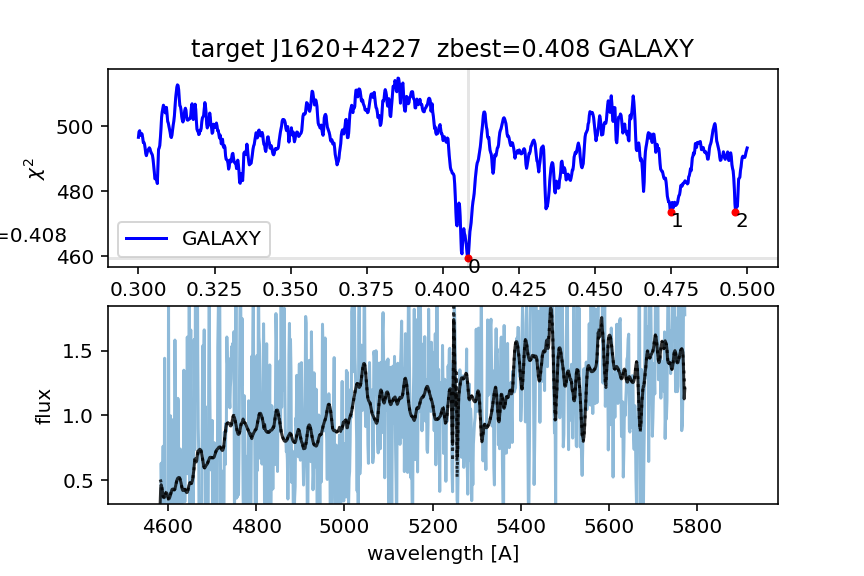

-------------------------------------------------------------------------
Select window then use keyboard shortcuts to navigate:
    up/down arrow: previous/next target
    left/right arrow: previous/next redshift fit for this target
    (d)etails
-------------------------------------------------------------------------
target 0 id J1620+4227 znum 0 GALAXY z=0.408


In [69]:
r2n = gbm(pixbound2n,sig_conv2n)

# Create redrock spectrum object and target object
rrSpecObj2n = obj.Spectrum(flux = newSpec_cut2n.flux.value,
                         ivar = 1/newSpec_cut2n.sig.value**2,
                         wave = newSpec_cut2n.wavelength.value,
                         R = r2n)
rrTargObj2n = obj.Target('J1620+4227', [rrSpecObj2n])

# Redshift time (AKA, the moment of truth)
zscan2n, zfit2n = zfind([rrTargObj2n], [galTemp])
intPlots2n = ps([rrTargObj2n] , [galTemp] , zscan2n , zfit2n)
intPlots2n

In [70]:
zfit2n

chi2,coeff [10],z,zerr,zwarn,zz [15],zzchi2 [15],spectype,subtype,targetid,znum,deltachi2
float64,float64,float64,float64,int64,float64,float64,str6,str1,str10,int64,float64
459.529073212,-73.4894020191 .. 178.235696616,0.408224372533,0.00020077630988,0,0.408108108108 .. 0.408508508509,459.858841425 .. 461.615174091,GALAXY,,J1620+4227,0,13.9704726562
473.499545868,-214.845025893 .. -71.8654855807,0.474861384837,0.000176231973552,4,0.474574574575 .. 0.474974974975,475.668455854 .. 473.948848024,GALAXY,,J1620+4227,1,0.0989197455347
473.598465614,429.337466391 .. 116.206353537,0.496151461663,0.000107784121457,4,0.495995995996 .. 0.496396396396,476.072500172 .. 475.673538349,GALAXY,,J1620+4227,2,0.0


Crap. Our zbest isn't what it should be. (In fact, the point labelled (1) above is the one we want.)

# J2223+0137

In [76]:
data = load_spec_kast_hdf5(data_pth + 'J2223+0137_coadd_new.hdf5')

wav3 = data[0]*u.AA
flux3 = data[1]/u.AA
err3 = data[2]
sig3 = np.sqrt(err3)

# Cut the ranges for consistency
flux3_cut = flux3[60:1019]
wav3_cut = wav3[60:1019]
err3_cut = err3[60:1019]
sig3_cut = sig3[60:1019]

#Create Xspectrum1D object
spec_cut3 = XSpectrum1D.from_tuple((wav3_cut,flux3_cut,sig3_cut),verbose = True)
newSpec_cut3 = elg.rebin2ConstVel(spec_cut3, do_sig = True, grow_bad_sig = True)

pixbound3 = np.append(newSpec_cut3.wavelength.value, spec_cut3.wvmax.value)
sig_conv3 = newSpec_cut3.sig.value

We have 1 spectra with 959 pixels each.


In [77]:
print 'Minimum sigma value is',np.min(sig_conv3)
for i in range(len(sig_conv3)):    
    if sig_conv3[i] <= 0.:
        print i , sig_conv3[i] , wav3[i] , "... Fixing zero values with median"
        sig_conv3[i] = np.median(sig_conv3)
print "New minimum is" , np.min(sig_conv3)
print "Wavelength coverage is", wav3_cut[0], "-", wav3_cut[-1]
print "Matrix shapes are" , np.shape(sig_conv3), np.shape(pixbound3) #check that they have a difference of 1 element

Minimum sigma value is 0.0
474 0.0 5084.17709669 Angstrom ... Fixing zero values with median
475 0.0 5085.42127139 Angstrom ... Fixing zero values with median
476 0.0 5086.66555175 Angstrom ... Fixing zero values with median
New minimum is 0.839954
Wavelength coverage is 4579.473083 Angstrom - 5773.76708058 Angstrom
Matrix shapes are (954,) (955,)


INFO: using multiprocessing with 2 cores
DEBUG: PID 3991 starting zchi2 scan for GALAXY


<IPython.core.display.Javascript object>


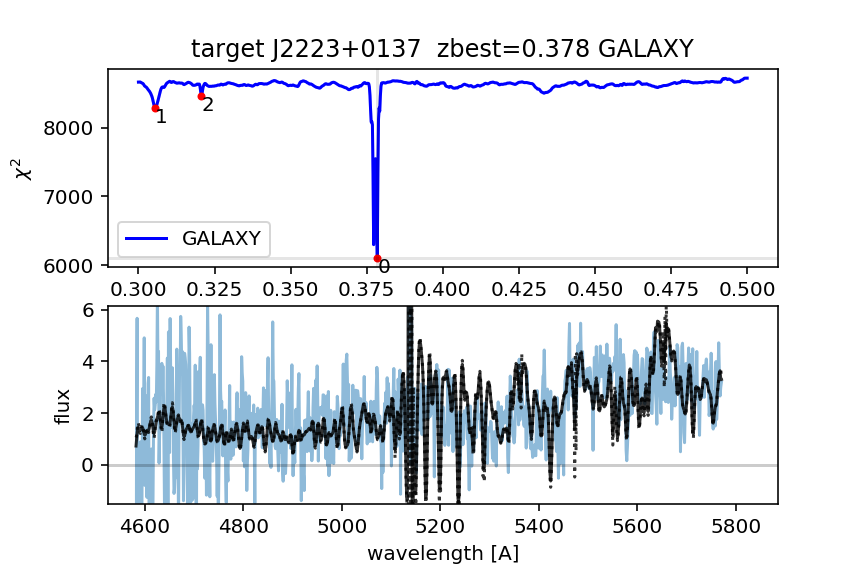

-------------------------------------------------------------------------
Select window then use keyboard shortcuts to navigate:
    up/down arrow: previous/next target
    left/right arrow: previous/next redshift fit for this target
    (d)etails
-------------------------------------------------------------------------
target 0 id J2223+0137 znum 0 GALAXY z=0.378


In [79]:
r3 = gbm(pixbound3,sig_conv3)

# Create redrock spectrum object and target object
rrSpecObj3 = obj.Spectrum(flux = newSpec_cut3.flux.value,
                         ivar = 1/sig_conv3**2,
                         wave = newSpec_cut3.wavelength.value,
                         R = r3)
rrTargObj3 = obj.Target('J2223+0137', [rrSpecObj3])

# Redshift time (AKA, the moment of truth)
zscan3, zfit3 = zfind([rrTargObj3], [galTemp])
intPlots3 = ps([rrTargObj3] , [galTemp] , zscan3 , zfit3)
intPlots3

In [81]:
zfit3

chi2,coeff [10],z,zerr,zwarn,zz [15],zzchi2 [15],spectype,subtype,targetid,znum,deltachi2
float64,float64,float64,float64,int64,float64,float64,str6,str1,str10,int64,float64
6105.44344711,1861.09169855 .. 2787.25830431,0.378440685597,6.26555463277e-06,0,0.378278278278 .. 0.378678678679,6575.55247684 .. 7350.93087634,GALAXY,,J2223+0137,0,2187.60165065
8293.04509776,-4810.11521202 .. -317.703876211,0.305510841641,7.57991389328e-05,0,0.305405405405 .. 0.305805805806,8295.35782777 .. 8308.21632665,GALAXY,,J2223+0137,1,173.612086002
8466.65718377,284.899443454 .. 154.047611972,0.320703532727,3.24539195213e-05,4,0.32042042042 .. 0.320820820821,8534.30489237 .. 8479.33267393,GALAXY,,J2223+0137,2,0.0


# J2240+0053

In [82]:
data = load_spec_kast_hdf5(data_pth + 'J2240+0053_coadd_new.hdf5')

wav4 = data[0]*u.AA
flux4 = data[1]/u.AA
err4 = data[2]
sig4 = np.sqrt(err4)

# Cut the ranges for consistency
flux4_cut = flux4[60:1019]
wav4_cut = wav4[60:1019]
err4_cut = err4[60:1019]
sig4_cut = sig4[60:1019]

#Create Xspectrum1D object
spec_cut4 = XSpectrum1D.from_tuple((wav4_cut,flux4_cut,sig4_cut),verbose = True)
newSpec_cut4 = elg.rebin2ConstVel(spec_cut4, do_sig = True, grow_bad_sig = True)

pixbound4 = np.append(newSpec_cut4.wavelength.value, spec_cut4.wvmax.value)
sig_conv4 = newSpec_cut4.sig.value

We have 1 spectra with 959 pixels each.


In [83]:
print 'Minimum sigma value is',np.min(sig_conv4)
for i in range(len(sig_conv4)):    
    if sig_conv4[i] <= 0.:
        print i , sig_conv4[i] , wav4[i] , "... Fixing zero values with median"
        sig_conv4[i] = np.median(sig_conv4)
print "New minimum is" , np.min(sig_conv4)
print "Wavelength coverage is", wav4_cut[0], "-", wav4_cut[-1]
print "Matrix shapes are" , np.shape(sig_conv4), np.shape(pixbound4) #check that they have a difference of 1 element

Minimum sigma value is 0.0
794 0.0 5487.5987663 Angstrom ... Fixing zero values with median
795 0.0 5488.87132156 Angstrom ... Fixing zero values with median
796 0.0 5490.14394841 Angstrom ... Fixing zero values with median
New minimum is 1.12181
Wavelength coverage is 4579.91299844 Angstrom - 5774.2473781 Angstrom
Matrix shapes are (954,) (955,)


INFO: using multiprocessing with 2 cores
DEBUG: PID 3991 starting zchi2 scan for GALAXY


<IPython.core.display.Javascript object>


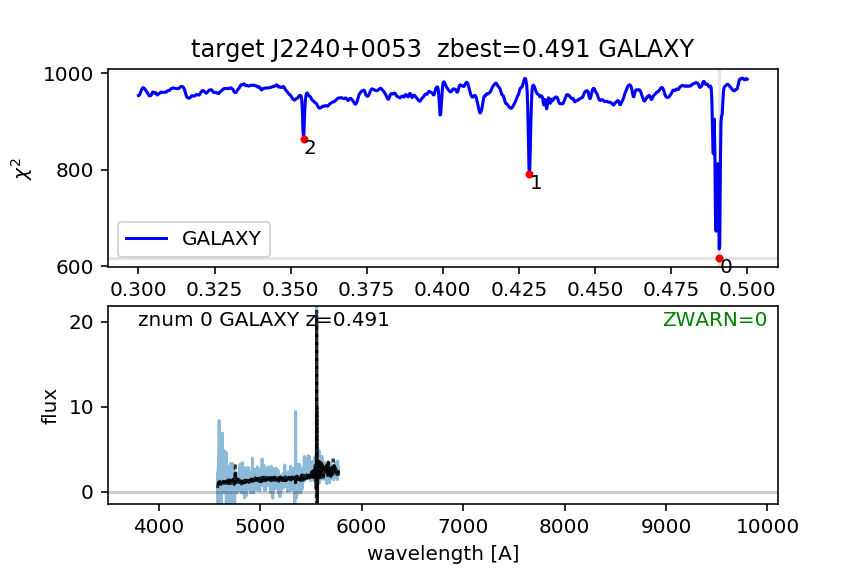

-------------------------------------------------------------------------
Select window then use keyboard shortcuts to navigate:
    up/down arrow: previous/next target
    left/right arrow: previous/next redshift fit for this target
    (d)etails
-------------------------------------------------------------------------
target 0 id J2240+0053 znum 0 GALAXY z=0.491


In [84]:
r4 = gbm(pixbound4,sig_conv4)

# Create redrock spectrum object and target object
rrSpecObj4 = obj.Spectrum(flux = newSpec_cut4.flux.value,
                         ivar = 1/sig_conv4**2,
                         wave = newSpec_cut4.wavelength.value,
                         R = r4)
rrTargObj4 = obj.Target('J2240+0053', [rrSpecObj4])

# Redshift time (AKA, the moment of truth)
zscan4, zfit4 = zfind([rrTargObj4], [galTemp])
intPlots4 = ps([rrTargObj4] , [galTemp] , zscan4 , zfit4)
intPlots4

In [85]:
zfit

chi2,coeff [10],z,zerr,zwarn,zz [15],zzchi2 [15],spectype,subtype,targetid,znum,deltachi2
float64,float64,float64,float64,int64,float64,float64,str6,str1,str10,int64,float64
493.526793273,-129.62954553 .. -72.0734154296,0.442312903238,0.000210374509927,4,0.442142142142 .. 0.442542542543,493.73577837 .. 494.307994633,GALAXY,,J1617+4232,0,0.812861200422
494.339654474,260.132001027 .. 109.876675225,0.453038749932,0.000217421620215,4,0.452752752753 .. 0.453153153153,495.426460395 .. 494.608921041,GALAXY,,J1617+4232,1,2.07302178815
496.412676262,-310.794476349 .. -15.5237371875,0.393585675192,0.000116190529414,4,0.393493493493 .. 0.393893893894,497.101024029 .. 497.798404364,GALAXY,,J1617+4232,2,0.0


Oh hell no. This one is waaaay off. Given these plots, I'd say that the current constraint on our zbest estimates are $z_{best} \pm 0.05$, which is awful and makes me want to cry.